# Investigating Biodiversity Intactness Index change in Phoenix Subdivision

#### Author: Naomi Moraes [(Personal Site)](https://nmoraescommit.github.io)
#### Repository Link: https://github.com/nmoraescommit/biodiversity_intact_index_phoenix

### Purpose:

"In 2021, Maricopa County — home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001 [1]." The urban sprawl initiated by this development has had serious impacts and holds concerning implications for the biodivesity of the surrounding natural environments. Biodiversity is attributed to the variety "within and among life forms on a site, ecosystem, or landscape.  Biodiversity is defined and measured as an attribute that has two components — richness and evenness." [2]

In this notebook, I investigate the impacts of the aforementioned metropolitan expansion through exploring, cleaning, and analyzing Biodiversity Intactness Index (BII) data (which measures biodiversity change using abundance data from fauna and flora worldwide [3]). Ultimately, I will visualize the change in BII data in the Phoenix county subdivion area - between the years 2017 and 2020.

### Highlights: 
Working through the provided problem allowed me to strengthen my understandng of working with the planetary_computer data and accessing data within retrieved catalogs. Through this excersize I have also able to work with census data and contextily, providing open source base maps for geospatial visualization. It was also a chance to work with raster math and raster pixel analysis.

### About the data:
- BII data: The BII dataset is retrieved from the Microsoft Planetary Computer STAC catalog's `io-biodiversity` collection, specifically the rasters representing the 2017 and 2020 BII. This dataset contains terrestrial BII data at 100m resolution,
- Phoenix Subdivision Shapefile: This data was retrieved from the 2024 United States Census Bureau TIGER/Shapeline county subdivisions shapefiles. The Phoenix subdivision polygon is used to crop our raster data, and provide an outline in the final map.

### Data Citations:
- Microsoft Planetary Computer. (n.d.). IO biodiversity dataset. Retrieved December 3, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity\n"
- U.S. Census Bureau. (2024). Arizona county subdivisions: tl_2024_04_cousub.shp [Shapefile dataset]. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2024&layergroup=County+Subdivisions \n",

### Text References
[1] Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/ [Accessed: Nov. 22, 2024]

[2] University of Idaho - College of Natural Resources. (n.d.). Principles of Vegetation Measurement & Assessment and Ecological Monitoring & Analysis. Why measure biodiversity https://www.webpages.uidaho.edu/veg_measure/modules/lessons/module%209(composition&diversity)/9_2_biodiversity.htm#:~:text=What%20is%20biodiversity%3F,genetically%20or%20functionally%20related%20individuals. [Accessed: Dec. 12, 2024]

[3] Biodiversity Intactness Index. (n.d.). [Video]. Natural History Museum. https://www.nhm.ac.uk/our-science/services/data/biodiversity-intactness-index.html [Accessed: Dec. 12, 2024]

### Acknowledgments
This repository contains materials for the second part of the final assignment for the course [EDS 220 - Working with Environmental Datasets](https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html), taught by Dr. Carmen Galaz García.

## Set-Up

### Import Libraries

In [1]:
# pip install libraries, should the module not be found

In [2]:
# Import general libraries 
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Import geospatial libraries
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import Polygon

# Import planetary computer tools
import pystac_client 
import planetary_computer

# for images and mapping
from IPython.display import Image
import contextily as ctx
from matplotlib.patches import Patch

### Import Data

Import the Arizona County Subdivison shapefile as well as read in the BII collection from the MPC STAC catalog. We will set-up a bounding box with geospatial and temporal characterstics, to define our desired area.

In [3]:
# Phoenix data
# Create path to data folder
arizona_fp = os.path.join("data","tl_2024_04_cousub.shp")

# Assign 2024 Phoenix subdivison shapefile US Census Bureau to variable
arizona_sub = gpd.read_file(arizona_fp)

In [4]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
# Create coordinates for bounding box
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],
            [-112.826843, 33.863574],
            [-111.184387, 33.863574],
            [-111.184387, 32.974108],
            [-112.826843, 32.974108]
        ]
    ],
}

# Specify tume range
time_range = "2017/2020"

In [6]:
# Search catalog
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

In [7]:
# Retrieve items
items = search.item_collection()

# View number of items in search
len(items)

# Manually explore items to find 2017 and 2020
items # The data is in the 1st and 4th items

# Select and name 2017 and 2020 items
bio_2017 = items[3]
bio_2020 = items[0]

## Data Analysis and Visualization

### Data Exploration

Take a look through the Arizona County subdivision shapefile. Observe relevant column names, data types, and CRS. This should give you a better sense of what the data contains and how we can use it to crop our raster data.

In [8]:
# Explore arizona_sub head
pd.set_option("display.max.columns", None)
arizona_sub.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


In [9]:
# Explore arizona_sub tail
arizona_sub.tail(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
77,04,003,90969,01934936,0400390969,0600000US0400390969,Douglas,Douglas CCD,22,Z5,G4040,S,641500771,176635,+31.4446761,-109.4183013,"POLYGON ((-109.79275 31.33442, -109.79266 31.3..."
78,04,003,93182,01934980,0400393182,0600000US0400393182,Sierra Vista,Sierra Vista CCD,22,Z5,G4040,S,1814147965,1074824,+31.7198887,-110.1649608,"POLYGON ((-110.46078 31.56927, -110.46078 31.5..."
79,04,003,91122,01934939,0400391122,0600000US0400391122,Elfrida,Elfrida CCD,22,Z5,G4040,S,4176450000,5652149,+31.6613311,-109.3906592,"POLYGON ((-110.03718 31.72418, -110.03617 31.7..."


In [10]:
arizona_sub.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [11]:
arizona_sub.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Data Processing

Simplify our column names for better data handling, and filter to retrieve the county subdivision of Phoenix, Arizona.

In [12]:
# Simplify column names by replacing spaces and no capitilization
arizona_sub.columns = (arizona_sub.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

In [13]:
# Select Phoenix County from Arizona subdivisions
phoenix = arizona_sub[arizona_sub['name'] == 'Phoenix']

### Phoenix Subdivision

Plot the selected Phoenix subdivsion on a basemap - here we have used an OpenStreetMap base from the `contextily` package. 

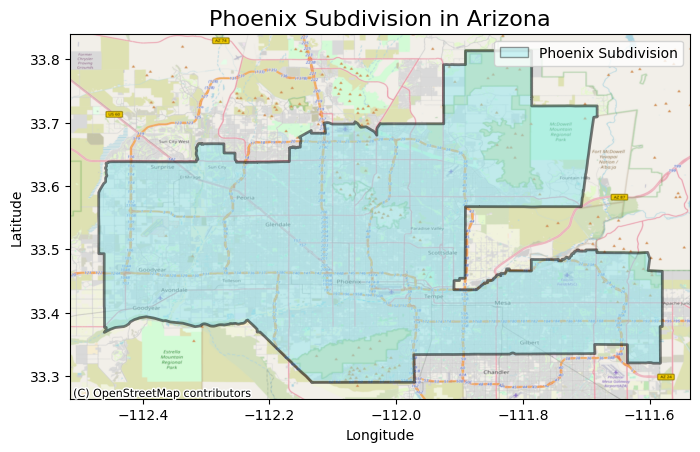

In [14]:
# Create Phoenix Map
fig, ax = plt.subplots(figsize = (8,8))

phoenix.plot(ax = ax,
             alpha = 0.5,
             edgecolor = "black",
             linewidth = 2,
             facecolor = '#8FE6EE')

# Add title
plt.title('Phoenix Subdivision in Arizona', fontsize = 16)

# Set axis labels
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude")

# Add legend
legend = [Patch(facecolor = '#8FE6EE', alpha = 0.4, edgecolor = 'black', label = 'Phoenix Subdivision')]
ax.legend(handles = legend)

# Add contextual basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.DE, crs = phoenix.crs)

# Plot
plt.show()

## Biodiversity Intactness in Phoenix, Arizona

### Explore Data

Explore the Biodiversity Intactness data for the years 2017 and 2020.

In [15]:
# Explore assets within bio_2017 and bio_2020
# bio_2017.assets # Uncomment to explore
# bio_2020.assets # Uncomment to explore

In [16]:
# Find assets within the 2017 items
for key in bio_2017.assets.keys():
    print(key, '--', bio_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [17]:
# Find assets within the 2020 items
for key in bio_2020.assets.keys():
    print(key, '--', bio_2020.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [18]:
# Plot rendered preview
# bio_2017_data
Image(url=bio_2017.assets['rendered_preview'].href, width=500)

In [19]:
# Image(url=bio_2020.assets['rendered_preview'].href, width=500) # Uncomment to view

In [20]:
# Retrieve 2017 biodiversity intactness data and href
bio_2017_asset = bio_2017.assets['data']
bio_2017_data = rioxr.open_rasterio(bio_2017_asset.href)

# Retrieve 2020 biodiversity intactness data and href
bio_2020_asset = bio_2020.assets['data']
bio_2020_data = rioxr.open_rasterio(bio_2020_asset.href)

### Clean Data

In order to complete our final change in BII figure we have to mask and crop our raster data. In order to do so we must make the CRS of all relevant data equal, the clip the rasters to our Phoenix subdivision polygon.

In [21]:
# Match CRS of selected data and Phoenix
bio_2017_data.rio.crs

CRS.from_epsg(4326)

In [22]:
# Check both data CRS match
assert(bio_2017_data.rio.crs == bio_2020_data.rio.crs)

In [25]:
# Reproject phoenix crs to EPSG 4326 
phoenix = phoenix.to_crs(bio_2017_data.rio.crs)

# Check all CRS match
assert((phoenix.crs == bio_2020_data.rio.crs) & (phoenix.crs == bio_2017_data.rio.crs))

In [26]:
# Clip 2017 raster to Phoenix
bio_2017_clip = bio_2017_data.rio.clip(phoenix['geometry'])

In [25]:
# Clip 2020 raster to Phoenix
bio_2020_clip =  bio_2020_data.rio.clip(phoenix['geometry'])

### Calculations

Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. First, find the number of pixels in each year that meet the condition BII ≥ 0.75.

In [26]:
# Find areas where bii >= 0.75. Assign 1 to true and 0 to false
phoenix_2017_bii_bool = (bio_2017_clip >= 0.75).astype(int)

# Same calculation for 2020. 
phoenix_2020_bii_bool = (bio_2020_clip >= 0.75).astype(int)

Transform the areas into percentages, by dividing the total number of pixels that meet the previous condition over total pixels and multiplying by 100.

In [27]:
# Number of pixels above 0.75 bii for 2017 and 2020
phoenix_2017_75_pixels = phoenix_2017_bii_bool.values.sum()
phoenix_2020_75_pixels = phoenix_2020_bii_bool.values.sum()

In [28]:
# Total pixels for each year
bio_2017_total_pixels = bio_2017_clip.count().item()
bio_2020_total_pixels = bio_2020_clip.count().item()

In [27]:
# Calculate percentages
phoenix_2017_pix_perc = (phoenix_2017_75_pixels / bio_2017_total_pixels)*100
phoenix_2020_pix_perc = (phoenix_2020_75_pixels / bio_2020_total_pixels)*100

NameError: name 'phoenix_2017_75_pixels' is not defined

In [30]:
# Print message with pixel percentafes
print(f"In 2017, {round(phoenix_2017_pix_perc, 2)}% of the Phoenix subdivision had a BII of at least 0.75" )
print(f"In 2020, {round(phoenix_2020_pix_perc, 2)}% of the Phoenix subdivision had a BII of at least 0.75" )

In 2017, 7.13% of the Phoenix subdivision had a BII of at least 0.75
In 2020, 6.49% of the Phoenix subdivision had a BII of at least 0.75


### Visualization of BII loss ( 2017 - 2020)

We have the percentages of area where the BII of the Phoenix subdivision were at least 75%. Now we must find the difference where the that BII loss is, spatially.

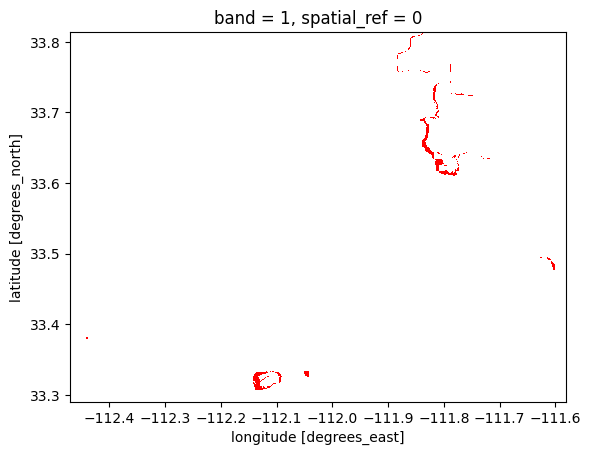

In [31]:
# Calculate difference between 2020 and 2017 pixels
bii_difference_pix = phoenix_2017_bii_bool - phoenix_2020_bii_bool

# Reclassify, such that pixels that are not 1 are NA
bii_loss_pix = (bii_difference_pix == 1).astype(int)

color_map = ["none", # set non-1 values to transparent
            "red"] # color loss areas red

# Create a colormap of color_map
cmap = plt.cm.colors.ListedColormap(color_map)

# Check
bii_loss_pix.plot(cmap = cmap, add_colorbar = False)

Finnaly, visualize the difference on the 2020 BII data cropped to Phoenix, AZ. Use the style shown in the assignment as a guide.

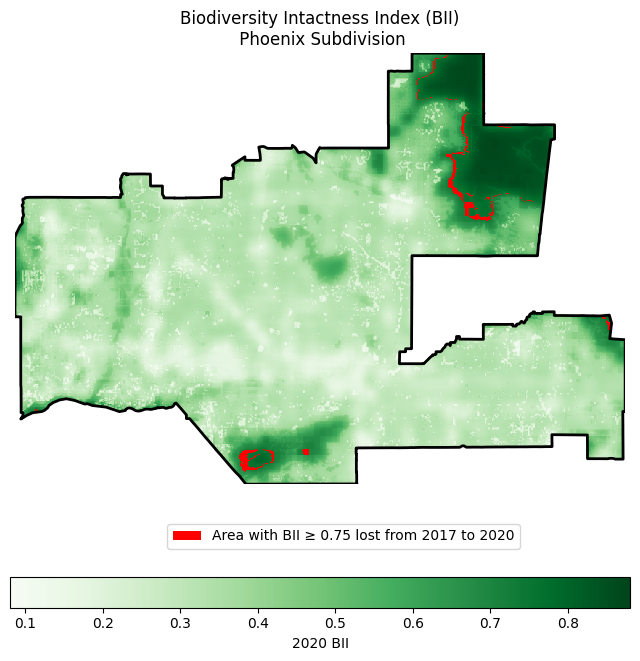

In [ ]:
# Create map
fig, ax = plt.subplots(figsize = (8, 8)) # Set figure size

ax.axis('off')

# Plot BII for 2020
bio_2020_clip.plot(ax=ax,
                   cmap = 'Greens',
                   cbar_kwargs={'orientation':'horizontal', 
                                'label':'2020 BII'})

# Plot BII loss 
bii_loss_pix.plot(ax=ax,
                  cmap = cmap,
                  add_colorbar = False)

# Plot Phoenix outline
phoenix.plot(ax = ax,
             color = "none",
             edgecolor = "black",
             linewidth = 2)

# Create patch for BII loss legend
legend = [Patch(facecolor = 'red', label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')]

ax.legend(handles=legend, loc=(0.25, -0.15)) # Legend

ax.set_title("Biodiversity Intactness Index (BII)\n Phoenix Subdivision")

plt.show()

Figure Description: This figure shows the BII values in the Phoenix subdivision, in 2020. The majority of the figure is a lighter green, representing lower BII values. BII loss greater than 75%, between the years 2017 to 2020, are represented in red. These red patches are primarily in dark green areas (areas with high BII values).